# Aspect-Based Sentiment Analysis of iPhone 11 Customer Reviews

**Author:** Robert Mezian
**Date:** April 5, 2025

## Introduction

This project aims to perform Aspect-Based Sentiment Analysis (ABSA) on customer reviews for the Apple iPhone 11. The goal is to identify specific features or aspects of the phone mentioned in the reviews (e.g., camera, battery life, screen) and determine the sentiment (Positive, Negative, or Neutral) expressed towards each aspect. This provides more granular insights than traditional overall sentiment analysis or star ratings.

**Dataset:**
The analysis uses the "iPhone Reviews from Amazon.com" dataset obtained from Kaggle, which contains over 30,000 reviews scraped from Amazon.com, including review text and ratings. (Dataset link: [https://www.kaggle.com/datasets/thedevastator/apple-iphone-11-reviews-from-amazon-com](https://www.kaggle.com/datasets/thedevastator/apple-iphone-11-reviews-from-amazon-com))

**Approach:**
The process involves several stages:
1.  **Data Loading & Exploration:** Loading the data and performing initial exploratory analysis.
2.  **Text Preprocessing:** Cleaning the review text by lowercasing, removing punctuation/numbers, and then using spaCy for lemmatization and stop word removal.
3.  **Aspect Extraction:** Identifying potential aspects using frequency analysis (CountVectorizer) and matching against a predefined list of relevant iPhone features.
4.  **Sentiment Assignment:** Using NLTK's VADER sentiment analyzer on sentences containing the identified aspects to determine aspect-specific sentiment.
5.  **Analysis & Visualization:** Summarizing and visualizing the sentiment associated with each aspect.

**Key Libraries:**
* Pandas (Data manipulation)
* NLTK (Sentiment analysis - VADER, sentence tokenization)
* spaCy (Text preprocessing - lemmatization, stop words)
* Scikit-learn (Feature extraction - CountVectorizer)
* Matplotlib & Seaborn (Data visualization)
* re (Regular expressions for cleaning)

In [2]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import re
import time
from collections import Counter

# --- NLP Libraries ---
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configure Settings (Optional) ---
# sns.set_style('whitegrid')
# plt.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.max_columns', 50) # Show more columns in DataFrame outputs
pd.set_option('display.max_colwidth', 100) # Show more text in columns

# --- Download necessary NLTK/spaCy data (Run once if needed) ---
# Encapsulate in try-except to avoid errors on subsequent runs
print("Checking/downloading necessary NLP resources...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK 'punkt'...")
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt')
except LookupError:
    print("Downloading NLTK 'vader_lexicon'...")
    nltk.download('vader_lexicon', quiet=True)
try:
    # This specific resource caused issues before
    nltk.data.find('tokenizers/punkt_tab/english')
except LookupError:
    print("Downloading NLTK 'punkt_tab'...")
    nltk.download('punkt_tab', quiet=True)

try:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
except OSError:
    print("Downloading spaCy 'en_core_web_sm' model...")
    # Ensure you run this command in your terminal if the ! fails in notebook sometimes:
    # python -m spacy download en_core_web_sm
    import subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

print("\nSetup Complete. Libraries imported and resources checked/downloaded.")

Checking/downloading necessary NLP resources...

Setup Complete. Libraries imported and resources checked/downloaded.


In [3]:
# --- Cell 1 (renumbered for notebook context): Loading Data ---
print("--- Loading Data ---")
# Make sure this filename is exactly correct and the file is in the right directory
csv_filename = 'apple_iphone_11_reviews.csv'
df = None # Initialize df to None

try:
    # Assuming the index column from Kaggle isn't needed, use index_col=0
    df = pd.read_csv(csv_filename, index_col=0)
    print(f"Successfully loaded '{csv_filename}'.")
    print(f"DataFrame shape: {df.shape}")

    # --- Basic Info & Verification ---
    print("\n--- Data Info ---")
    df.info()
    print("\n--- First 5 Rows ---")
    print(df.head())

    if df is None or df.empty:
         print("\nError: df is None or empty after loading!")
         raise ValueError("DataFrame loading failed.")
    else:
        print("\n✅ Data loaded successfully.")

except FileNotFoundError:
    print(f"\n❌ ERROR: File not found: '{csv_filename}'. Please ensure it's in the same directory as the notebook or provide the full path.")
except Exception as e:
    print(f"\n❌ ERROR: An unexpected error occurred during loading: {e}")

--- Loading Data ---
Successfully loaded 'apple_iphone_11_reviews.csv'.
DataFrame shape: (5010, 11)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 5010 entries, 0 to 5009
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product          5010 non-null   object
 1   helpful_count    5010 non-null   object
 2   total_comments   5010 non-null   int64 
 3   url              5010 non-null   object
 4   review_country   5010 non-null   object
 5   reviewed_at      5010 non-null   object
 6   review_text      5007 non-null   object
 7   review_rating    5010 non-null   object
 8   product_company  5010 non-null   object
 9   profile_name     5010 non-null   object
 10  review_title     5008 non-null   object
dtypes: int64(1), object(10)
memory usage: 469.7+ KB

--- First 5 Rows ---
                              product                    helpful_count  \
index                                        

## Exploratory Data Analysis (EDA)

Before cleaning the text, let's explore the dataset briefly to understand its characteristics. We'll look at:
* Missing values
* Distribution of review ratings
* Distribution of review text length

--- EDA ---

--- Missing Values per Column ---
product            0
helpful_count      0
total_comments     0
url                0
review_country     0
reviewed_at        0
review_text        3
review_rating      0
product_company    0
profile_name       0
review_title       2
dtype: int64

--- Review Rating Distribution ---
review_rating
1.0 out of 5 stars     319
2.0 out of 5 stars      87
3.0 out of 5 stars     153
4.0 out of 5 stars     720
5.0 out of 5 stars    3731
Name: count, dtype: int64


C:\Users\ramez\AppData\Local\Temp\ipykernel_23332\2748339134.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='review_rating', data=df, palette='viridis')


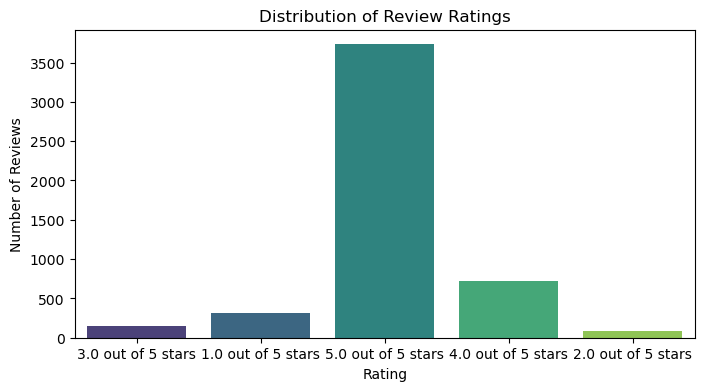


--- Review Text Length Distribution ---


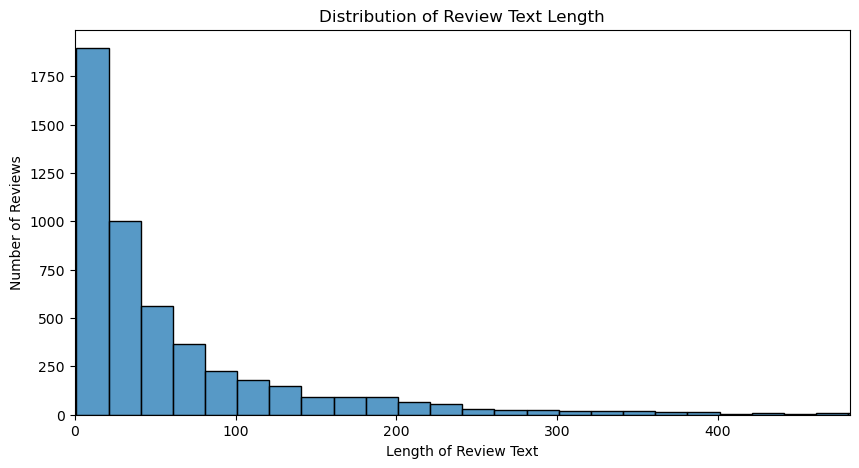


Average review length: 65.58 characters
count    5010.000000
mean       65.577046
std        94.688447
min         1.000000
25%        13.000000
50%        31.000000
75%        75.000000
max      1001.000000
Name: review_length, dtype: float64


In [4]:
if 'df' in locals() and isinstance(df, pd.DataFrame):
    print("--- EDA ---")

    # 1. Missing Values
    print("\n--- Missing Values per Column ---")
    print(df.isnull().sum())
    # Consider how to handle missing review_text later if any exist

    # 2. Rating Distribution
    print("\n--- Review Rating Distribution ---")
    if 'review_rating' in df.columns:
        rating_counts = df['review_rating'].value_counts().sort_index()
        print(rating_counts)
        # Plot
        plt.figure(figsize=(8, 4))
        sns.countplot(x='review_rating', data=df, palette='viridis')
        plt.title('Distribution of Review Ratings')
        plt.xlabel('Rating')
        plt.ylabel('Number of Reviews')
        plt.show()
    else:
        print("'review_rating' column not found.")

    # 3. Review Length Distribution
    print("\n--- Review Text Length Distribution ---")
    # Make sure to use the correct text column name identified earlier
    review_text_col = 'review_text' # <--- Confirm this is correct!
    if review_text_col in df.columns:
        # Ensure text is string before calculating length, handle potential NaNs
        df['review_length'] = df[review_text_col].astype(str).apply(len)
        plt.figure(figsize=(10, 5))
        sns.histplot(df['review_length'], bins=50, kde=False)
        plt.title('Distribution of Review Text Length')
        plt.xlabel('Length of Review Text')
        plt.ylabel('Number of Reviews')
        plt.xlim(0, df['review_length'].quantile(0.99)) # Limit x-axis to exclude extreme outliers
        plt.show()
        print(f"\nAverage review length: {df['review_length'].mean():.2f} characters")
        print(df['review_length'].describe())
    else:
        print(f"'{review_text_col}' column not found.")

else:
    print("DataFrame 'df' not available for EDA.")

## Text Preprocessing

To prepare the review text for analysis, we perform several preprocessing steps:
1.  **Handle Missing Values:** Fill any missing review text with empty strings.
2.  **Lowercasing:** Convert all text to lowercase for consistency.
3.  **Remove Punctuation & Numbers:** Eliminate punctuation marks and digits using regular expressions.
4.  **Lemmatization & Stop Word Removal:** Use spaCy to tokenize the text, remove common English stop words (like "the", "is", "a"), and reduce remaining words to their base/dictionary form (lemma).

We create new columns (`cleaned_text`, `lemmatized_text`) to store the results, preserving the original review text.

In [5]:
# --- Cell 2 (renumbered): Initial Cleaning ---
import re
import pandas as pd # Ensure pandas is available

print("--- Initial Cleaning ---")
# Make sure review_text_col is correctly defined (should be 'review_text' based on EDA)
review_text_col = 'review_text'

if 'df' in locals() and isinstance(df, pd.DataFrame): # Check if df exists from Cell 1
    if review_text_col in df.columns:
        try:
            # Ensure correct column name before creating cleaned_text
            df['cleaned_text'] = df[review_text_col]
            # Corrected fillna
            df['cleaned_text'] = df['cleaned_text'].fillna('')
            df['cleaned_text'] = df['cleaned_text'].str.lower()
            # Remove punctuation (keeps letters, numbers, whitespace) - updated regex
            df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
            # Remove numbers
            df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\d+', '', str(x)))
            print("Created 'cleaned_text' column successfully.")
            # Display comparison
            print("\n--- Original vs Cleaned Text Examples ---")
            print(df[[review_text_col, 'cleaned_text']].head())

            print("\n✅ Cell Verification: 'cleaned_text' column created.")
        except Exception as e:
            print(f"❌ ERROR in Initial Cleaning: {e}")
    else:
         print(f"❌ ERROR: Column '{review_text_col}' not found in DataFrame.")
         print(f"Available columns: {df.columns.tolist()}")
else:
    print("❌ DataFrame 'df' does not exist or is not a DataFrame. Cannot perform initial cleaning.")

--- Initial Cleaning ---
Created 'cleaned_text' column successfully.

--- Original vs Cleaned Text Examples ---
                                                                                               review_text  \
index                                                                                                        
0                                                                                                    NOTE:   
1      Very bad experience with this iPhone xr phone. Back camera found defective and non functional. A...   
2                    Amazing phone with amazing camera coming from iPhone 7 plus great service from amazon   
3      So I got the iPhone XR just today. The product looks amazing. But unfortunately the Face ID is n...   
4      I've been an android user all my life until I decided to try iPhone XR for iOS. Loving the camer...   

                                                                                              cleaned_text  
index   

In [6]:
# --- Cell 3 (renumbered): spaCy Lemmatization ---
import spacy
import time
import pandas as pd # Ensure pandas is available

print("--- spaCy Lemmatization ---")

# Ensure spaCy model 'nlp' is loaded (it should be from Cell 2 imports if run sequentially)
if 'nlp' not in locals() or nlp is None:
     print("❌ ERROR: spaCy model 'nlp' not loaded. Please check Cell 2 (Setup and Imports).")
     # Attempt to load again as a fallback
     try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        print("spaCy model loaded successfully now.")
     except Exception as e:
        print(f"Failed to load spaCy model here too: {e}")


# Check df and required input column exist before processing
if 'df' in locals() and isinstance(df, pd.DataFrame) and 'cleaned_text' in df.columns and 'nlp' in locals() and nlp is not None:
    try:
        print("Starting lemmatization and stop word removal...")
        start_time = time.time()
        lemmatized_texts = []
        # Use .loc to ensure we work with the actual DataFrame slice
        texts_to_process = df.loc[df['cleaned_text'].notna() & (df['cleaned_text'] != ''), 'cleaned_text']

        for doc in nlp.pipe(texts_to_process, batch_size=50):
            # Filter out stop words, punctuation, spaces, and get lemma
            tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
            lemmatized_texts.append(" ".join(tokens)) # Join lemmas back into string

        # Safely create and assign to the new column using the index from texts_to_process
        df['lemmatized_text'] = pd.Series(dtype='string') # Initialize column
        if not texts_to_process.empty:
            # Align using index
            df.loc[texts_to_process.index, 'lemmatized_text'] = lemmatized_texts
        df['lemmatized_text'] = df['lemmatized_text'].fillna('') # Fill rows that weren't processed

        end_time = time.time()
        print(f"Lemmatization finished in {end_time - start_time:.2f} seconds.")
        print("Created 'lemmatized_text' column successfully.")

        # Display comparison
        print("\n--- Cleaned vs Lemmatized Text Examples ---")
        print(df[['cleaned_text', 'lemmatized_text']].head())

        print("\n✅ Cell Verification: 'lemmatized_text' column created.")

    except Exception as e:
        print(f"❌ ERROR occurred during lemmatization: {e}")
elif 'df' not in locals() or not isinstance(df, pd.DataFrame):
     print("❌ DataFrame 'df' doesn't exist or is invalid.")
elif 'cleaned_text' not in df.columns:
     print("❌ 'cleaned_text' column missing.")
elif 'nlp' not in locals() or nlp is None:
     print("❌ spaCy model 'nlp' not loaded.")

--- spaCy Lemmatization ---
Starting lemmatization and stop word removal...
Lemmatization finished in 3.00 seconds.
Created 'lemmatized_text' column successfully.

--- Cleaned vs Lemmatized Text Examples ---
                                                                                              cleaned_text  \
index                                                                                                        
0                                                                                                     note   
1      very bad experience with this iphone xr phone back camera found defective and non functional ama...   
2                     amazing phone with amazing camera coming from iphone  plus great service from amazon   
3      so i got the iphone xr just today the product looks amazing but unfortunately the face id is not...   
4      ive been an android user all my life until i decided to try iphone xr for ios loving the camera ...   

                     

## Aspect Extraction

To identify the specific product features discussed, we use a keyword-based approach combined with frequency analysis.
1.  **Frequency Analysis:** We use `CountVectorizer` on the lemmatized text to find the most common single words and two-word phrases (bigrams), removing standard English stop words. This helps identify potential aspect terms.
2.  **Predefined Aspect List:** Based on domain knowledge (common iPhone features) and informed by the frequency analysis, we define a list of relevant aspect keywords.
3.  **Keyword Matching:** For each review, we check if any of the predefined aspect keywords are present in the lemmatized text. Boolean columns (`has_camera`, `has_battery_life`, etc.) are added to the DataFrame to flag reviews mentioning each aspect. We use regular expressions with word boundaries (`\b`) to ensure more precise matching.

In [7]:
# --- Cell 4 (renumbered): Aspect Extraction ---
from sklearn.feature_extraction.text import CountVectorizer # Ensure import
import re # Ensure import
import pandas as pd # Ensure import

print("--- Aspect Extraction ---")

# Check conditions BEFORE doing anything else
if 'df' not in locals() or not isinstance(df, pd.DataFrame):
    print("❌ ERROR before starting: DataFrame 'df' does not exist or is invalid.")
elif 'lemmatized_text' not in df.columns:
    print(f"❌ ERROR before starting: Column 'lemmatized_text' not found in df. Columns are: {df.columns.tolist()}")
else:
    print("Conditions met: 'df' exists and contains 'lemmatized_text'. Proceeding...")
    # --- Start of Aspect Extraction Code ---
    try:
        # 1. Frequency Analysis
        print("\nPerforming frequency analysis on lemmatized text...")
        vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=5) # min_df=5 means word must appear in at least 5 reviews
        text_to_vectorize = df['lemmatized_text'].fillna('')
        X = vectorizer.fit_transform(text_to_vectorize)
        feature_names = vectorizer.get_feature_names_out()
        word_counts = X.sum(axis=0).A1
        word_freq = pd.DataFrame({'word': feature_names, 'frequency': word_counts})
        word_freq_sorted = word_freq.sort_values(by='frequency', ascending=False)
        print("\n--- Top 20 Most Frequent Terms (Potential Aspects) ---")
        print(word_freq_sorted.head(20))

        # 2. Define Aspect List (Review and customize this!)
        print("\nDefining aspect list...")
        iphone_aspects = [
            "battery", "life", "battery life", # Battery related
            "camera", "photo", "picture", "video", "lens", "zoom", # Camera related
            "screen", "display", "oled", "brightness", # Screen related
            "performance", "speed", "fast", "chip", "processor", # Performance
            "price", "cost", "value", "money", # Price/Value
            "design", "look", "feel", "color", "size", "build", # Design/Build
            "storage", "memory", "gb", # Storage
            "ios", "software", "update", "app", "feature", # Software
            "sound", "speaker", "audio", # Sound
            "service", "support", "apple", # Service/Brand
            "phone", "iphone", # General product terms (less specific as aspects)
            "charge", "cable", "port", "usbc" # Charging related
        ]
        print(f"Defined aspects list: {len(iphone_aspects)} items")
        iphone_aspects_lower = [aspect.lower() for aspect in iphone_aspects]
        aspect_bool_columns = [f"has_{aspect.replace(' ', '_')}" for aspect in iphone_aspects_lower] # Store the column names

        # 3. Keyword Matching
        print("\nChecking for predefined aspects in reviews...")
        aspect_results = {}
        for aspect in iphone_aspects_lower:
            col_name = f"has_{aspect.replace(' ', '_')}"
            # Use regex word boundaries; handle potential regex errors in aspect string
            try:
                pattern = r'\b' + re.escape(aspect) + r'\b'
                aspect_results[col_name] = df['lemmatized_text'].str.contains(pattern, regex=True, na=False)
            except re.error:
                print(f"Warning: Skipping aspect '{aspect}' due to regex issue.")
                aspect_results[col_name] = False # Assign False if pattern is invalid

        aspect_df = pd.DataFrame(aspect_results)
        cols_to_add = [col for col in aspect_df.columns if col not in df.columns]
        if cols_to_add:
             df = pd.concat([df, aspect_df[cols_to_add]], axis=1)
             print(f"\nAdded {len(cols_to_add)} boolean aspect columns to the DataFrame.")
             print("Example columns:", cols_to_add[:5])
        else:
             print("\nAspect columns already seem to exist. No new columns added.")


        # Display Sample Output
        print("\n--- Sample of reviews with identified aspects ---")
        # Use the generated list of boolean columns that should now exist in df
        relevant_aspect_cols = [col for col in aspect_bool_columns if col in df.columns]
        if relevant_aspect_cols: # Check if any aspect columns exist
             reviews_with_aspects = df[df[relevant_aspect_cols].any(axis=1)]
             cols_to_display = ['lemmatized_text'] + relevant_aspect_cols[:5] # Show first 5 aspect cols
             print(reviews_with_aspects[cols_to_display].head())
        else:
             print("No aspect columns found in DataFrame to display sample.")

        print("\n✅ Aspect extraction completed.")

    except Exception as e:
        print(f"\n❌ ERROR occurred during aspect extraction: {e}")
        import traceback
        traceback.print_exc()

--- Aspect Extraction ---
Conditions met: 'df' exists and contains 'lemmatized_text'. Proceeding...

Performing frequency analysis on lemmatized text...

--- Top 20 Most Frequent Terms (Potential Aspects) ---
              word  frequency
413           good       1861
761          phone       1567
535         iphone        962
851        product        834
95         battery        723
157         camera        562
46           apple        517
74         awesome        448
585           life        438
456          great        417
101   battery life        402
1186            xr        384
888        quality        378
23          amazon        363
142            buy        358
693           nice        338
317      excellent        328
831          price        309
15         amazing        275
340           face        253

Defining aspect list...
Defined aspects list: 48 items

Checking for predefined aspects in reviews...

Added 48 boolean aspect columns to the DataFrame.
Example

## Sentiment Assignment

Now that we have identified reviews likely discussing specific aspects, we assign sentiment to those aspects.
1.  **Tool:** We use NLTK's VADER (Valence Aware Dictionary and sEntiment Reasoner), which is well-suited for review text. It provides a compound score from -1 (negative) to +1 (positive).
2.  **Process:**
    * For each review where an aspect is flagged (e.g., `has_camera` is True):
    * We tokenize the *original review text* into sentences.
    * We find the specific sentences containing the aspect keyword(s).
    * We calculate the VADER compound score for each of these relevant sentences.
    * We average the compound scores for all sentences related to that aspect within the review.
    * We classify the average score into "Positive" (>= 0.05), "Negative" (<= -0.05), or "Neutral".
3.  **Output:** The results are stored in a new `aspect_sentiments` column, where each entry is a dictionary mapping the identified aspects in that review to their calculated sentiment label.

In [8]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import re
import time

print("--- Sentiment Assignment ---")

# --- Ensure VADER and punkt are loaded (already done in Cell 2 ideally) ---
try:
    sia = SentimentIntensityAnalyzer()
    # Test if vader_lexicon exists
    _ = sia.polarity_scores("test")
    print("VADER Analyzer ready.")
except LookupError:
    print("❌ ERROR: VADER lexicon not found. Please check Cell 2 (Setup and Imports).")
    sia = None

try:
    _ = sent_tokenize("test sentence.")
except LookupError:
     print("❌ ERROR: NLTK 'punkt'/'punkt_tab' not found. Please check Cell 2 (Setup and Imports).")
     # Set flag to skip processing if needed
     sia = None # Prevent analysis if sentence tokenizer fails


# Ensure the aspect list and boolean columns are available
# (Redefine iphone_aspects_lower and aspect_bool_columns if running this cell independently)
if 'iphone_aspects_lower' not in locals() or 'aspect_bool_columns' not in locals():
    print("Redefining aspect lists...")
    iphone_aspects = [
        "battery", "life", "battery life", "camera", "photo", "picture", "video", "lens", "zoom",
        "screen", "display", "oled", "brightness", "performance", "speed", "fast", "chip", "processor",
        "price", "cost", "value", "money", "design", "look", "feel", "color", "size", "build",
        "storage", "memory", "gb", "ios", "software", "update", "app", "feature", "sound", "speaker", "audio",
        "service", "support", "apple", "phone", "iphone", "charge", "cable", "port", "usbc"
    ]
    iphone_aspects_lower = [aspect.lower() for aspect in iphone_aspects]
    aspect_bool_columns = [f"has_{aspect.replace(' ', '_')}" for aspect in iphone_aspects_lower]


# Use original text for sentiment
review_text_col = 'review_text' # Make sure this is correct

def get_aspect_sentiments(row):
    """ Analyzes sentences containing aspects within a single review row. """
    if sia is None: return {} # Don't proceed if VADER failed
    # Ensure text is a string and boolean columns exist
    if not isinstance(row[review_text_col], str) or not all(col in row.index for col in aspect_bool_columns):
        return {}

    try:
        sentences = sent_tokenize(row[review_text_col])
    except Exception as e:
        # print(f"Warning: Could not sentence tokenize row index {row.name}: {e}")
        return {} # Cannot proceed without sentences

    aspect_sentiments = {}

    for aspect in iphone_aspects_lower:
        aspect_col_name = f"has_{aspect.replace(' ', '_')}"
        # Check if aspect is marked present for this row and column exists
        if aspect_col_name in row.index and row[aspect_col_name] == True:
            relevant_sentences_scores = []
            try:
                # Simple pattern for single/multi-word aspects
                pattern_words = aspect.split()
                if len(pattern_words) == 1:
                     pattern = r'\b' + re.escape(pattern_words[0]) + r'\b'
                else: # Simple multi-word: find first and last word near each other
                     pattern = r'\b' + re.escape(pattern_words[0]) + r'\b.*?\b' + re.escape(pattern_words[-1]) + r'\b'

                for sentence in sentences:
                    if re.search(pattern, sentence, re.IGNORECASE):
                         score = sia.polarity_scores(sentence)['compound']
                         relevant_sentences_scores.append(score)

            except re.error:
                 # print(f"Warning: Regex error for aspect '{aspect}'")
                 continue # Skip aspect if regex fails

            if relevant_sentences_scores:
                avg_score = sum(relevant_sentences_scores) / len(relevant_sentences_scores)
                if avg_score >= 0.05: sentiment_label = "Positive"
                elif avg_score <= -0.05: sentiment_label = "Negative"
                else: sentiment_label = "Neutral"
                aspect_sentiments[aspect] = sentiment_label

    return aspect_sentiments


# --- Apply the function ---
if ('df' in locals() and isinstance(df, pd.DataFrame) and
    review_text_col in df.columns and
    all(col in df.columns for col in aspect_bool_columns) and
    sia is not None):

    print("\nApplying sentiment analysis to identified aspects (this may take time)...")
    start_time = time.time()

    # Apply the function row-wise
    df['aspect_sentiments'] = df.apply(get_aspect_sentiments, axis=1)

    end_time = time.time()
    print(f"Sentiment analysis finished in {end_time - start_time:.2f} seconds.")

    # --- Display Sample Output ---
    print("\n--- Sample of Reviews with Aspect Sentiments ---")
    reviews_with_sentiment = df[df['aspect_sentiments'].apply(lambda x: isinstance(x, dict) and bool(x))]
    if not reviews_with_sentiment.empty:
        # Show some boolean columns along with the result
        display_cols = [review_text_col] + aspect_bool_columns[:3] + ['aspect_sentiments']
        # Ensure columns exist before trying to display
        display_cols = [col for col in display_cols if col in reviews_with_sentiment.columns]
        print(reviews_with_sentiment[display_cols].head())
    else:
        print("No aspects with sentiment found in the sample (or function needs refinement).")

    print("\n✅ Sentiment assignment completed.")

else:
    print("❌ Cannot run sentiment analysis: Prerequisites missing (df, review column, aspect columns, or VADER).")

--- Sentiment Assignment ---
VADER Analyzer ready.

Applying sentiment analysis to identified aspects (this may take time)...
Sentiment analysis finished in 1.53 seconds.

--- Sample of Reviews with Aspect Sentiments ---
                                                                                               review_text  \
index                                                                                                        
1      Very bad experience with this iPhone xr phone. Back camera found defective and non functional. A...   
2                    Amazing phone with amazing camera coming from iPhone 7 plus great service from amazon   
3      So I got the iPhone XR just today. The product looks amazing. But unfortunately the Face ID is n...   
4      I've been an android user all my life until I decided to try iPhone XR for iOS. Loving the camer...   
5      I was delivered a phone that did not work immediately after removing from the box. I was not abl...   

       h

## Results Analysis & Visualization

With the aspect sentiments calculated, we can now aggregate and visualize the findings to understand the overall opinion towards different iPhone 11 features.
1.  **Aggregate Counts:** We count the total number of Positive, Negative, and Neutral mentions for each aspect across all reviews.
2.  **Visualize:** We create a bar chart showing the Positive and Negative counts for the most frequently discussed aspects.

In [9]:
# --- Cell (renumbered): Analyzing Aspect Sentiment Counts ---
import pandas as pd
from collections import Counter

print("--- Aggregating Aspect Sentiment Counts ---")

# Check prerequisites
if ('df' in locals() and isinstance(df, pd.DataFrame) and
    'aspect_sentiments' in df.columns):

    aspect_sentiment_counts = Counter()

    # Iterate through the dictionaries in the aspect_sentiments column
    for sentiments_dict in df['aspect_sentiments']:
        if isinstance(sentiments_dict, dict): # Check if it's a dictionary
            for aspect, sentiment in sentiments_dict.items():
                aspect_sentiment_counts[(aspect, sentiment)] += 1

    # Convert the counter to a DataFrame
    sentiment_summary = []
    if aspect_sentiment_counts: # Check if counter is not empty
        for (aspect, sentiment), count in aspect_sentiment_counts.items():
            sentiment_summary.append({'aspect': aspect, 'sentiment': sentiment, 'count': count})
        sentiment_summary_df = pd.DataFrame(sentiment_summary)

        # Pivot the table
        sentiment_pivot = sentiment_summary_df.pivot_table(index='aspect', columns='sentiment', values='count', fill_value=0)

        # Ensure standard sentiment columns exist
        for col in ['Positive', 'Negative', 'Neutral']:
            if col not in sentiment_pivot.columns:
                sentiment_pivot[col] = 0

        # Add a total count column and sort
        sentiment_pivot['total'] = sentiment_pivot[['Positive', 'Negative', 'Neutral']].sum(axis=1)
        sentiment_pivot = sentiment_pivot.sort_values(by='total', ascending=False)

        print("\n--- Sentiment Counts per Aspect ---")
        print(sentiment_pivot)

        print("\n--- Aspects mentioned most often (Top 10) ---")
        print(sentiment_pivot.head(10))

        print("\n✅ Sentiment aggregation completed.")
    else:
        print("No sentiments were extracted to aggregate.")
        sentiment_pivot = None # Ensure variable exists but is None

else:
    print("❌ Could not analyze sentiments: 'df' or 'aspect_sentiments' column not found.")
    sentiment_pivot = None # Ensure variable exists but is None

--- Aggregating Aspect Sentiment Counts ---

--- Sentiment Counts per Aspect ---
sentiment     Negative  Neutral  Positive   total
aspect                                           
phone            133.0    159.0     982.0  1274.0
iphone            74.0    152.0     484.0   710.0
battery           68.0     87.0     534.0   689.0
camera            50.0     54.0     402.0   506.0
life              36.0     47.0     345.0   428.0
apple             45.0     74.0     296.0   415.0
battery life      35.0     42.0     318.0   395.0
price             26.0     37.0     219.0   282.0
money             18.0      5.0     139.0   162.0
performance       18.0     21.0     111.0   150.0
screen            26.0     38.0      67.0   131.0
fast              11.0     39.0      70.0   120.0
value              4.0      0.0     115.0   119.0
display           19.0     19.0      74.0   112.0
service           19.0     12.0      27.0    58.0
feel              11.0      7.0      37.0    55.0
charge             

--- Visualizing Aspect Sentiments ---


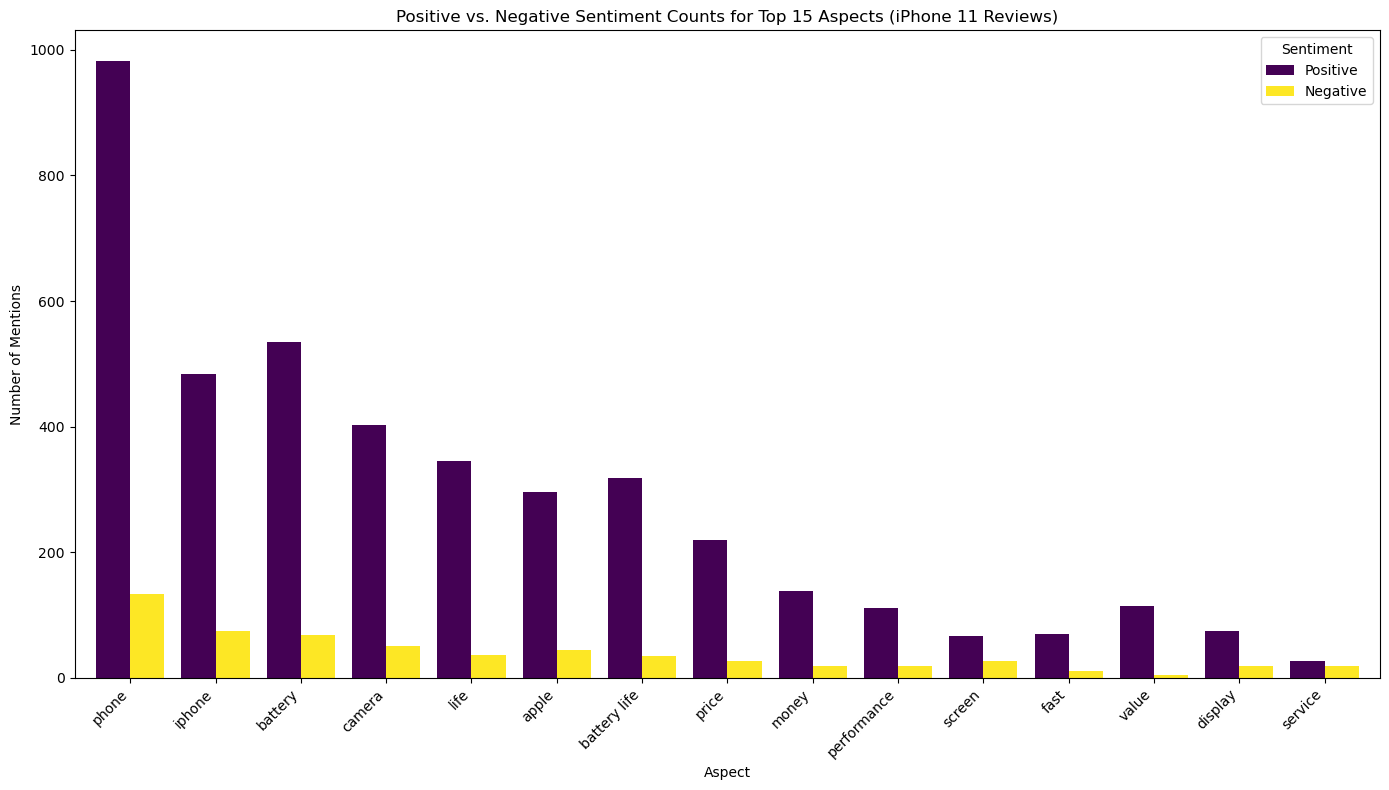


✅ Sentiment visualization completed.


In [10]:
# --- Cell (renumbered): Visualizing Aspect Sentiments ---
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Visualizing Aspect Sentiments ---")

# Check if sentiment_pivot exists and is a DataFrame
if 'sentiment_pivot' in locals() and isinstance(sentiment_pivot, pd.DataFrame) and not sentiment_pivot.empty:
    # Select top N aspects to plot
    top_n = 15
    plot_data = sentiment_pivot.head(top_n).copy()

    # Keep only Positive and Negative for the comparison plot
    plot_data = plot_data[['Positive', 'Negative']]

    # Plotting
    if not plot_data.empty:
        plot_data.plot(kind='bar', figsize=(14, 8), width=0.8, colormap='viridis') # Changed colormap

        plt.title(f'Positive vs. Negative Sentiment Counts for Top {top_n} Aspects (iPhone 11 Reviews)')
        plt.ylabel('Number of Mentions')
        plt.xlabel('Aspect')
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
        plt.legend(title='Sentiment')
        plt.tight_layout() # Adjust layout
        plt.show()
        print("\n✅ Sentiment visualization completed.")
    else:
        print("Not enough Positive/Negative data in sentiment_pivot to plot.")

else:
    print("❌ Could not visualize sentiments: 'sentiment_pivot' DataFrame not found or is empty.")

## Interpretation of Results

**(Based on the table and plot generated above, discuss your findings here.)**

* **Most Discussed Aspects:** Which aspects appeared most frequently in the sentiment analysis (look at the `total` column in the `sentiment_pivot` table)? Does this make sense for phone reviews?
* **Most Positive Aspects:** Which aspects had the highest number of positive mentions? What does the bar chart show as clear positives?
* **Most Negative Aspects:** Which aspects had the highest number of negative mentions? Are there any features that received significant criticism according to the bar chart?
* **Mixed Aspects:** Are there any aspects with high counts for *both* positive and negative sentiment? What might this indicate?
* **Overall Summary:** What is the general feeling towards the iPhone 11 based on this aspect-level analysis?
* **(Add specific numbers or observations from your results)**

## Conclusion

**(Summarize the project and reflect on it.)**

**Summary:**
This project successfully performed Aspect-Based Sentiment Analysis on iPhone 11 reviews. Key steps included text preprocessing, extracting relevant aspects using keyword analysis, and assigning sentiment to those aspects using VADER. The analysis revealed [mention 1-2 key findings from your interpretation section - e.g., the camera was highly praised, while opinions on battery life were more divided].

**Limitations:**
* The aspect extraction method relied on a predefined keyword list and simple string matching, which might miss some aspects or misclassify mentions.
* Sentiment analysis used VADER, which is lexicon-based and may not capture complex nuances like sarcasm or context-dependent sentiment as accurately as transformer models.
* The analysis was based on a single dataset for one product model (iPhone 11) from one source (Amazon). Results might differ for other models, time periods, or platforms.
* Sentiment was assigned based on the average score of sentences containing the aspect; more sophisticated methods could link sentiment more directly to the aspect phrase.

**Future Work:**
* Implement more advanced aspect extraction techniques (e.g., using dependency parsing or named entity recognition).
* Utilize more sophisticated sentiment analysis models (e.g., fine-tuning BERT or using other transformer-based models).
* Expand the analysis to compare different iPhone models or competitors.
* Analyze the evolution of aspect sentiment over time if timestamps allow.
* Develop an interactive dashboard or tool to explore the results.